In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
import tensorflow.keras.optimizers as optimizers
import os, glob, math
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
dir(optimizers)

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'deserialize',
 'get',
 'schedules',
 'serialize']

# 0. Data Analysis
We first need to check whether the data are consistent, in terms of image dimension.

In [3]:
train_width, train_height = [], []
train_channel = set()
test_width, test_height = [], []
test_channel = set()

In [4]:
for animal in ['dogs', 'cats']:
    animaux = animal[:-1]
    for fname in glob.glob(os.path.join('data', 'train', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        train_width.append(w)
        train_height.append(h)
        train_channel.add(im.getbands())
    for fname in glob.glob(os.path.join('data', 'validation', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        test_width.append(w)
        test_height.append(h)
        test_channel.add(im.getbands())

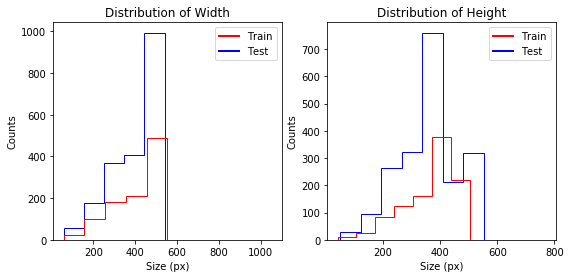

In [5]:
fig = plt.figure(figsize=(9, 4))
from matplotlib.lines import Line2D
custom_lines = [Line2D([1], [1], color='red', lw=2),
                Line2D([1], [1], color='blue', lw=2)]
plt.subplot(1, 2, 1)
plt.title('Distribution of Width')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_width, label='trainWidth', color='blue', histtype='step')
plt.hist(test_width, label='testWidth', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.subplot(1, 2, 2)
plt.title('Distribution of Height')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_height, label='trainHeight', color='blue', histtype='step')
plt.hist(test_height, label='testHeight', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.show()

In [6]:
df_dist = pd.DataFrame(index=['MedianWidth', 'MedianHeight'])
from fractions import Fraction
df_dist['Train'] = pd.Series({'MedianWidth': np.median(train_width),
                              'MedianHeight': np.median(train_height)})
df_dist['Test'] = pd.Series({'MedianWidth': np.median(test_width),
                              'MedianHeight': np.median(test_height)})
df_dist['Average'] = df_dist.mean(axis=1)
df_dist = df_dist.astype(int)
display (df_dist)

,Train,Test,Average
MedianWidth,442,448,445
MedianHeight,374,374,374


In [7]:
train_channel, test_channel

({('R', 'G', 'B')}, {('R', 'G', 'B')})

# 1. Model Initialisation & Training
We know that the colour channels are concordant between the datasets, i.e. RGB, so we can hardcode it appropriately during data loading. Also, due to the distribution of the dataset dimensions, let's take and rescale to the average of the median values.

In [23]:
BATCH_SIZE = 32
epochs = 3
AVG_MED_WIDTH = 200#int(df_dist.loc['MedianWidth', 'Average']/2)
AVG_MED_HEIGHT = 200#int(df_dist.loc['MedianHeight', 'Average']/2)
print (f'AVG MED WIDTH {AVG_MED_WIDTH}')
print (f'AVG MED HEIGHT {AVG_MED_HEIGHT}')

AVG MED WIDTH 200
AVG MED HEIGHT 200


In [24]:
print ("Training Data")
train_data = ImageDataGenerator(
                rescale=1./255
                ).flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'train'),
                    target_size=(AVG_MED_WIDTH, AVG_MED_HEIGHT),
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'])

print ("Test Data")
test_data = ImageDataGenerator(
                rescale=1./255
                ).flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'validation'),
                    target_size=(AVG_MED_WIDTH, AVG_MED_HEIGHT),
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'])

Training Data
Found 2000 images belonging to 2 classes.
Test Data
Found 1000 images belonging to 2 classes.


In [25]:
sample_train, label = next(train_data)
num_train_data = train_data.n
num_test_data = test_data.n

In [26]:
labelName = {0.:'cats', 1.:'dogs'}

In [27]:
train_data.n

2000

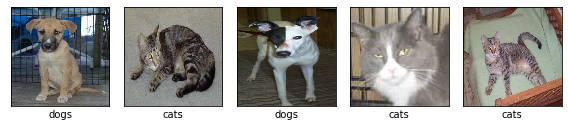

In [28]:
def plotImages(images_arr, label_arr):
    fig, axes = plt.subplots(1, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, dataLabel, ax in zip(images_arr, label_arr, axes):
        ax.imshow(img)
        ax.set_xlabel(labelName[dataLabel])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()

plotImages(sample_train[:5], label[:5])

In [33]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_uniform',
                           input_shape=(AVG_MED_WIDTH, AVG_MED_HEIGHT ,3)),
    MaxPooling2D(2, strides=1),
#     Dropout(0.2),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(2, strides=1),    
#     Dropout(0.2),    
#     Conv2D(128, 3, padding='same', activation='relu'),
#     MaxPooling2D(2, strides=1),
    Dropout(0.2),    
    Flatten(),
    Dense(96, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[633616,96] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Add] name: dense_14/kernel/Initializer/random_uniform/

In [19]:
history = model.fit(train_data, 
                    steps_per_epoch=math.ceil(num_train_data/32), 
                    epochs=epochs,
                    sample_weight=None,
                    )

  ...
    to  
  ['...']
Train for 63 steps
Epoch 1/3
63/63 [==============================] - 56s 890ms/step - loss: 15.3153 - accuracy: 0.4955 - AUC: 0.4848 - Precision: 0.4952 - Recall: 0.4690
Epoch 2/3
63/63 [==============================] - 55s 873ms/step - loss: 0.5998 - accuracy: 0.6795 - AUC: 0.7449 - Precision: 0.6997 - Recall: 0.6290
Epoch 3/3
63/63 [==============================] - 55s 881ms/step - loss: 0.4236 - accuracy: 0.8230 - AUC: 0.9080 - Precision: 0.8289 - Recall: 0.8140


In [22]:
model = None

In [21]:
import gc
gc.collect()

20